# Zillow Home Value Index in the Past 25 years

**Andrea Mendoza** 

**MSDS 430**

**Spring 2025**

### Introduction:

My project is an overview of of the home price values in the Zillow Home Value Index data for the past 20 years in the United States. The goal of this project is to observe home prices across different cities in the united states, specifically in the midwest area and in Illinois.

I am also curious about the change in prices in the past 20 years across different cities.

I would like to see if there is different price growth in deifferent metro areas.

This subject is interesting to me because I am beginning to look into purchasing my first home in the next couple of years, and I would like to understand housing costs in different cities that I might be intersted in living in. Since I grew up in Chicago, I would like to stay in Illinois or at least the midwest area.

My prediction is that home value prices near major cities will be higher than in other areas. I also think that home value prices have increased a lot in the past 20 years and perhaps the growth is higher in the past 5 years.

### Data:

The dataset I am using is the **Zillow Home Value Index (ZHVI)** data for all home types, by U.S. city, and for the years 2000 - 2025. The data is also categorized by state, size rank, metro area, and county.

Data is downloadable in the https://www.zillow.com/research/data/ site, by scrolling down to Data, and selecting ZHVI All Homes (SFR,Condo/Co-op) Time Series, Smoothed, Seasonally Adjusted ($), and filtering for City in the Geography section.

Steps used to clean data:
- I separated the long date to Month and Year, and converted it to the format='%Y-%m'). Then I dropped the pre-existing date columns from the file.
- Used value_counts() to identify rows that had missing values and got rid of any empty rows.
- Used melt to turn it from wide to long data.
- Did a box plot to observe any outlers, but decided to keep data despite large number of outliers becasue housing prices across states can vary by a lot.


My final data contains 3,892,771 rows and a total of 6 columns:

| Field Name| Description | Data Type |
| --- | --- | --- |
| State | State abbreviation | object |
| County | Name of county | object |
| Metro | Metro area identifier | object |
| Year | Year | object |
| Month | Month | object |
| Price | Home proces | float64 |



In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('/Users/andreamendoza/Desktop/MSDS300/EDA/clean_zillow.csv',header=0)
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3892771 entries, 0 to 3892770
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   State       object 
 1   CountyName  object 
 2   Metro       object 
 3   Year        int64  
 4   Month       int64  
 5   Price       float64
dtypes: float64(1), int64(2), object(3)
memory usage: 178.2+ MB


,State,CountyName,Metro,Year,Month,Price
0,NY,Queens County,"New York-Newark-Jersey City, NY-NJ-PA",2000,1,248689.10
1,CA,Los Angeles County,"Los Angeles-Long Beach-Anaheim, CA",2000,1,236075.64
2,TX,Harris County,"Houston-The Woodlands-Sugar Land, TX",2000,1,104985.42
3,IL,Cook County,"Chicago-Naperville-Elgin, IL-IN-WI",2000,1,128745.73
4,TX,Bexar County,"San Antonio-New Braunfels, TX",2000,1,99062.80


### Results

Since my dataset has so many rows due to the number of towns, months, and years, I decided to calculate the median price per year from 2000 to 2025. This method allows me to visualize the median housing prices for the past 25 years.

In [6]:
median_price_by_year = data.groupby('Year')['Price'].median().reset_index()
median_price_by_year.columns = ['Year', 'Median Price']
median_price_by_year['Median Price'] = median_price_by_year['Median Price'].round(2)
median_price_by_year.head()

,Year,Median Price
0,2000,127244.88
1,2001,134734.26
2,2002,141869.27
3,2003,150049.32
4,2004,160381.61


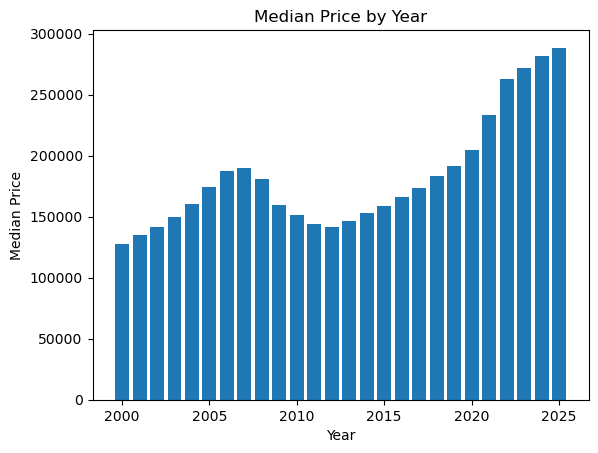

In [7]:
plt.bar(median_price_by_year['Year'], median_price_by_year['Median Price'])
plt.title('Median Price by Year')
plt.xlabel('Year')
plt.ylabel('Median Price')
plt.show();

We can clearly see that the median house prices dropped in year 2012 and rose more steeply between 2020 and 2022. Since 2012, prices have continued to rise, especially between 2021 to 2022, and they have not stopped rising.

Since home values have steadily risen, I would like to focus on home value prices since 2020 and see what the delta is year over year since 2020. I also would like to see which areas have the smallest and largest change since 2020.

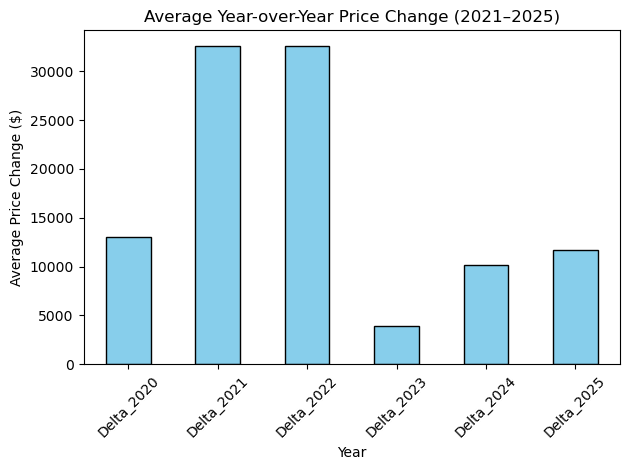

In [10]:
# Get the last 5 years only

last5 = data[data['Year'] >= 2019]

# calculate the delta year over year

Delta = last5.pivot_table(index=['State', 'CountyName', 'Metro', 'Month'], columns='Year', values='Price')
Delta = Delta.diff(axis=1).iloc[:, 1:].round(2) 
Delta.columns = [f'Delta_{col}' for col in Delta.columns]
Delta = Delta.reset_index()

# Get only the Delta columns
delta_cols = [col for col in Delta.columns if col.startswith('Delta_')]

# Compute average for each year
avg_deltas = Delta[delta_cols].mean().round(2)


# Plot
avg_deltas.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Year-over-Year Price Change (2021–2025)')
plt.ylabel('Average Price Change ($)')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show();


Looking at the average delta for price year over year. We can immeditaley see that after the Covid-19 pandemic, in 2020, the avergae change in price increased by about \\$19,000, but then dropped after 2022 by about \\$28,593. This sharp increase and sharp decrease indicates that that home values during the Covid-19 pandemic appracited in value but did not stay that way.

I think it would be useful to see that areas with the largest increase in prices for the year 2021.

**One of my hunches is that large metro areas are positively correlated to home value prices, some of the most well-known large metro areas are California, New York, and Chicago.**

Since we have so many metro areas I filtered for the top 15 metro areas with the highest number of rows, to plot them in a correlation matrix against price.

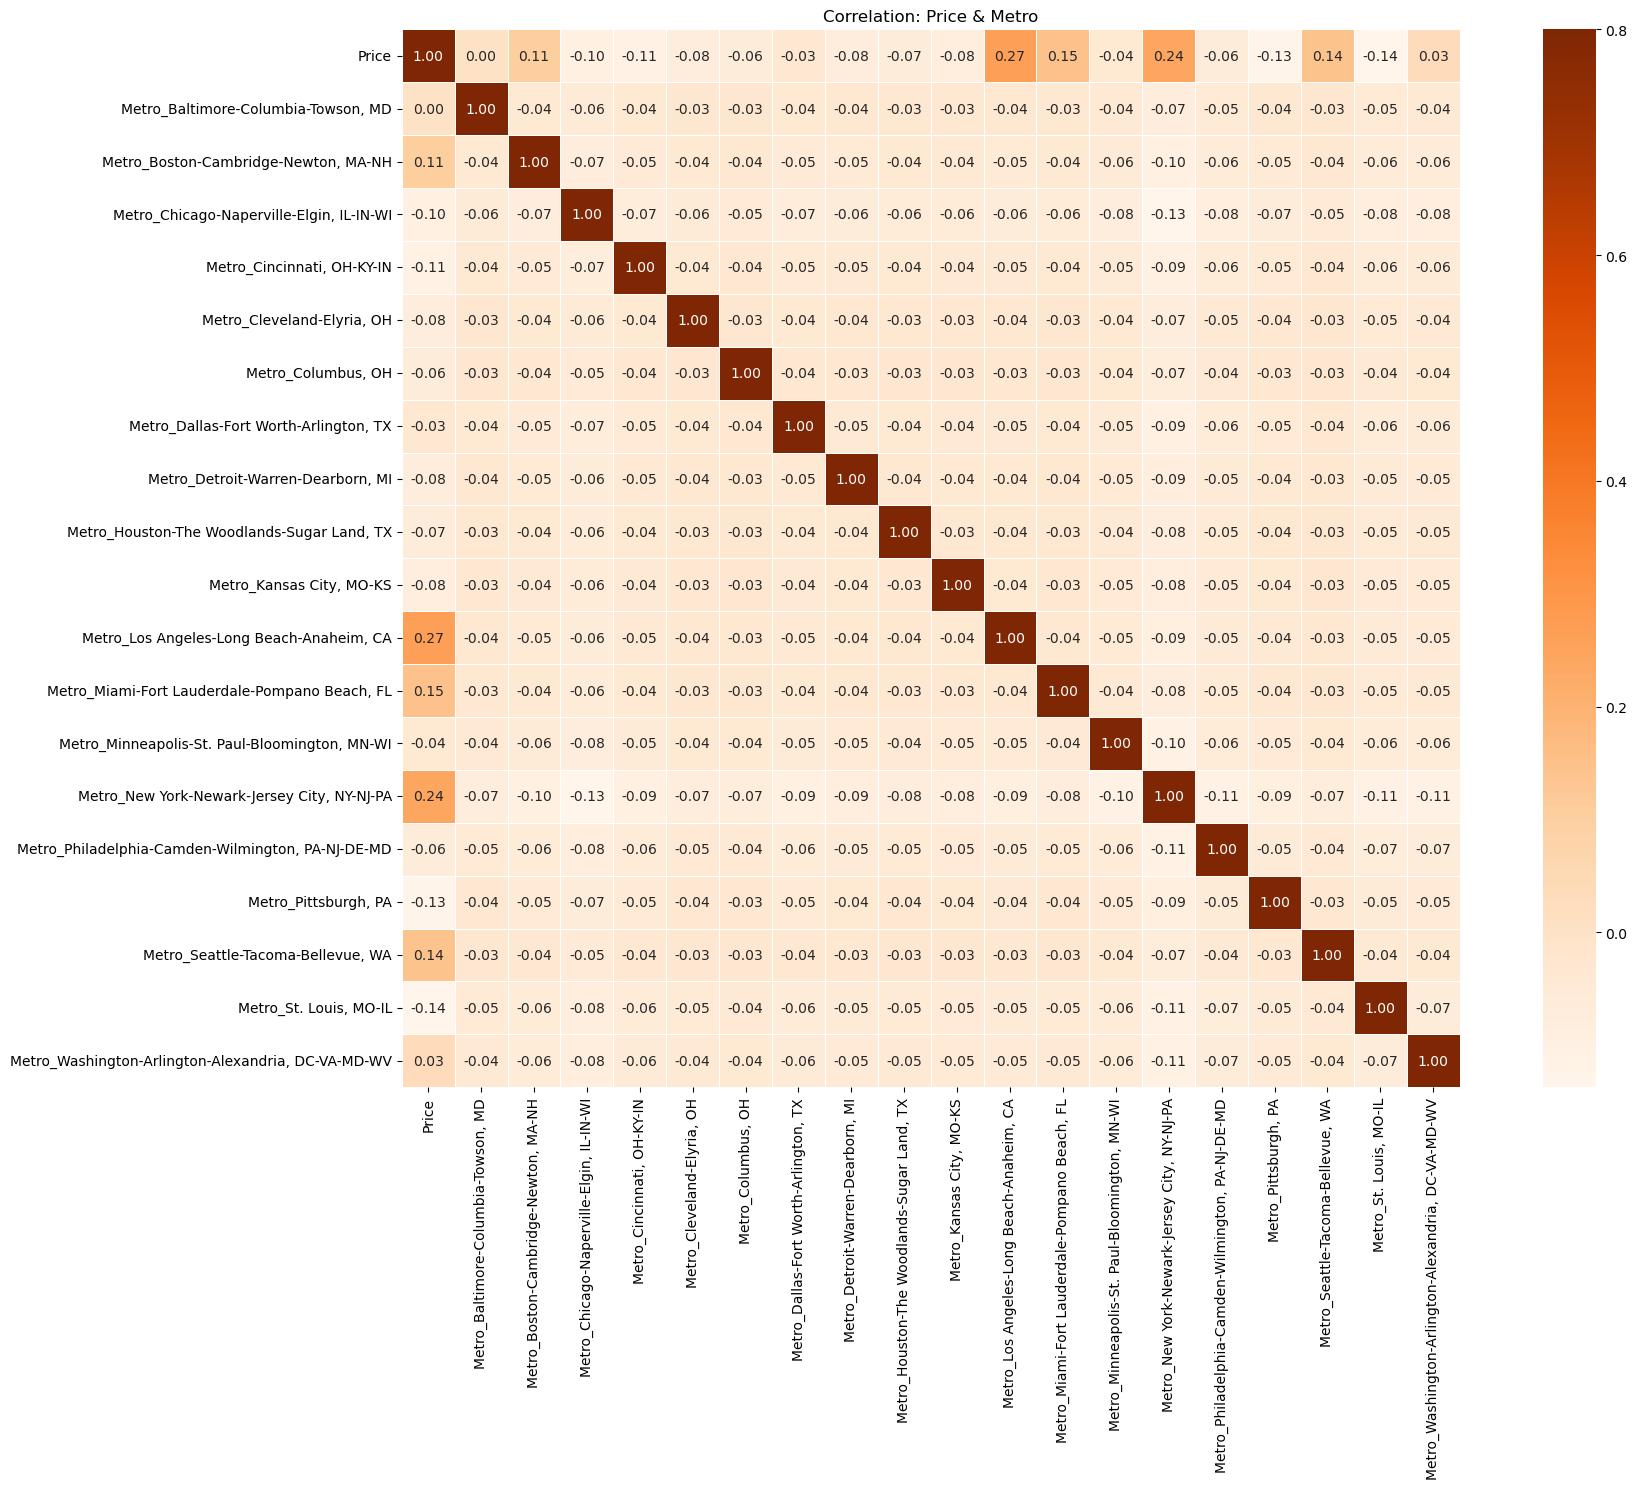

In [12]:
# United States Top 20 metro areas by number of rows
whole_metros = last5['Metro'].value_counts().head(20).index

# Filter to those metros
metros = last5[last5['Metro'].isin(whole_metros)]
dfcorr = pd.get_dummies(metros[['Metro', 'Price']], drop_first=True)

corr_mat = dfcorr.corr()

# Step 4: Plot heatmap
f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corr_mat, vmax=0.8, square=True, annot=True, fmt=".2f", cmap='Oranges', linewidths=0.5)
plt.title('Correlation: Price & Metro')
plt.tight_layout()
plt.show()

As we can see, our metro areas with the highest number of rows have mostly moderately weak correaltions, meaning that in most metro areas in the united states, prices are moderately lower than in other areas. Our metro area with the highest correlation to price (0.27) is Los Angeles-Long Beach-Anaheim, California. This is not surprising since LA has been on the news in recent years for their scarce housing and high housing costs.

The next positive correlation at (0.24) is New York-Newark-Jersey City-NY-NJ-PA. Consideirng that it is the metro area that includes New York City, I think this makes sense.

Our next metro areas with a positive correlation to price are Miami-Fort Lauderdale-Pompano Beach, FL and Seattle-Tacoma-Bellevue,WA. I should have expected to see a Florida metro area in this list, since they experince some of the highest housing prices in the country. Seattle's home prices have increased in the past 5 years and it makes sense for Seattle prices to be positively correlated as well. 

None of these metro areas have strong positive or negative corraletions with pricing, which would probably change if we dive into neighborhoods.

My metro area of interest is the Chicago metro area, becuase it is where I grew up, and I now live in the northern city of Evanston, which is above my desired price range. I would like to stay in Illinois, and preferably near Chicago in an affordable metro area.

According to this correlation matrix, the Chicago metro area, which is Chicago-Naperville-Elgin-IL-IN-WI, is slightly negatively correlated with price (-0.09). This means that in my area of interest, home prices are slighly lower than other metro areas in the United States.

Since I am most interested in home prices in Illinois, I am going to make a subset for home values in IL and compare metro areas by price, delta, and perhaps do a correlation between metro area and price. 

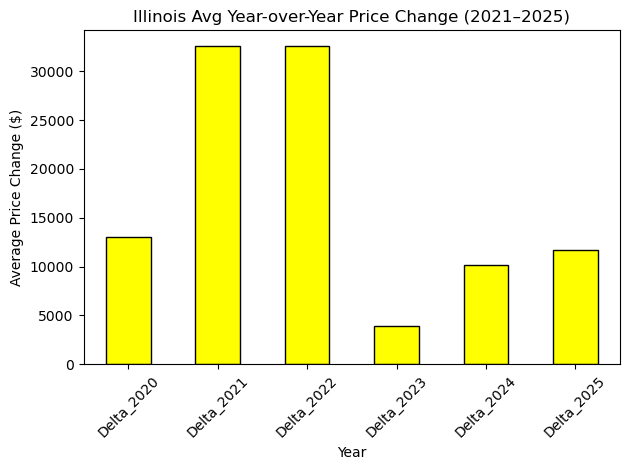

In [15]:
# Get IL Delta Columns for last 5 years
IL_last5 = last5[last5['State']== 'IL']
IL_delta = Delta[Delta['State']== 'IL']

# Get only the Delta columns
IL_delta_cols = [col for col in IL_delta.columns if col.startswith('Delta_')]

# Compute average for each year
IL_avg_deltas = Delta[delta_cols].mean().round(2)

# Plot
IL_avg_deltas.plot(kind='bar', color='yellow', edgecolor='black')
plt.title('Illinois Avg Year-over-Year Price Change (2021–2025)')
plt.ylabel('Average Price Change ($)')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


As we can see, the change in prices in Illinois resembles that of the rest of the country. 

I would like to see if there is a correlation between home value prices and metro area using price data for the last 5 years. But, since there are so many metro areas, I narrowed down my metric to the top 20 metro areas by frequency of rows. I figured that rows with the most metro areas have more housing, which would make them larger metro areas.


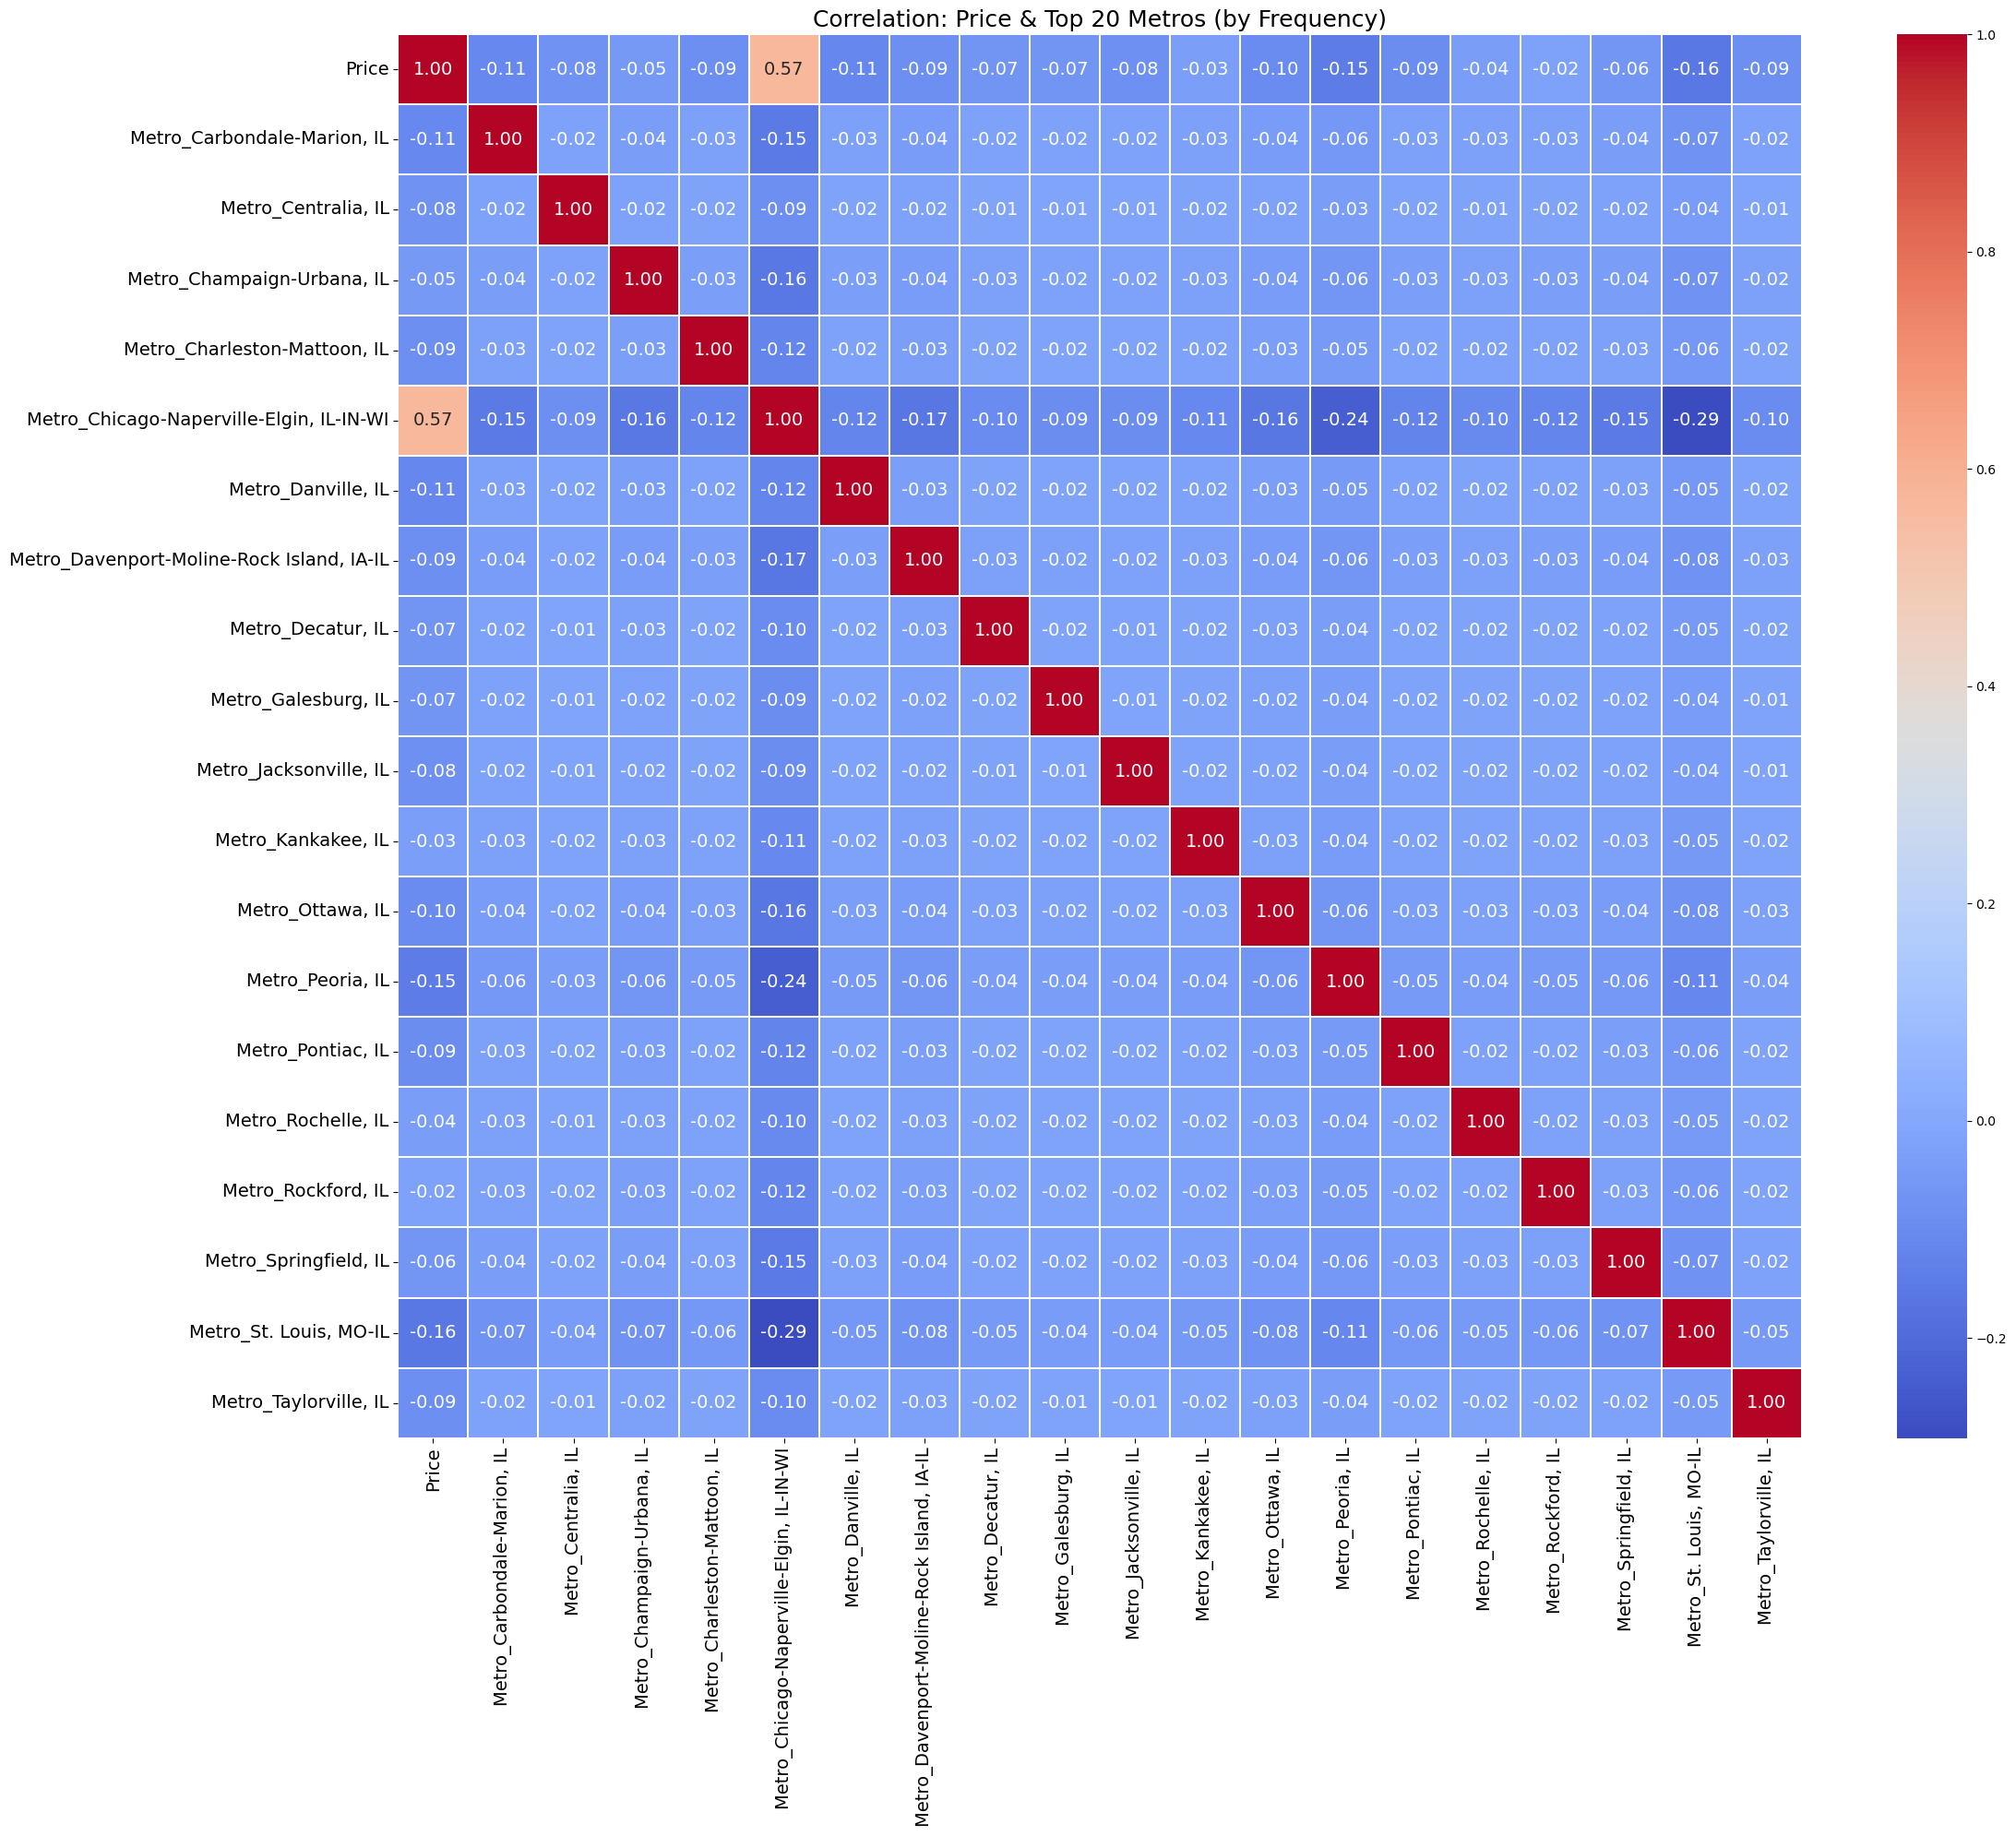

In [17]:
# Get top 20 Metros by number of rows
top_metros = IL_last5['Metro'].value_counts().nlargest(20).index

# Filter to only those Metros
filtered = IL_last5[IL_last5['Metro'].isin(top_metros)][['Metro', 'Price']]

# One-hot encode Metro
df_corr_encoded = pd.get_dummies(filtered, columns=['Metro'], drop_first=True)

# Correlation matrix
corrmat = df_corr_encoded.corr()

# Plot
f, ax = plt.subplots(figsize=(25, 20))
sns.heatmap(corrmat, vmax=1, square=True, annot=True, fmt=".2f", cmap='coolwarm',
            linewidths=0.2, annot_kws={"size": 14})
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
plt.title('Correlation: Price & Top 20 Metros (by Frequency)', fontsize=18)
plt.tight_layout()
plt.show()



We can see that most metro areas have a weak to negative corelation to prices. This means that prices are not necessariy impacted by the metro area, however, this is not true for the Metro_Chicago-Naperville-Elgin, IL-IN-WI. This is a very large metro area that encompasses Illinois, Wisconsin, and Indiana. This area probably includes northern and southern suburbs of Chicago, which extend to Wisconsin and Indiana. Naperville and Elgin and west of Chicago. Of all the Metro areas, this one is sligly (0.58) positively correlated with home value price.

Since these are still a lot of metro areas, I wanted to narrow down to the top 10 metro areas by number of rows. I hoped that my reducing the number of matro areas, we would get stronger correlation values.

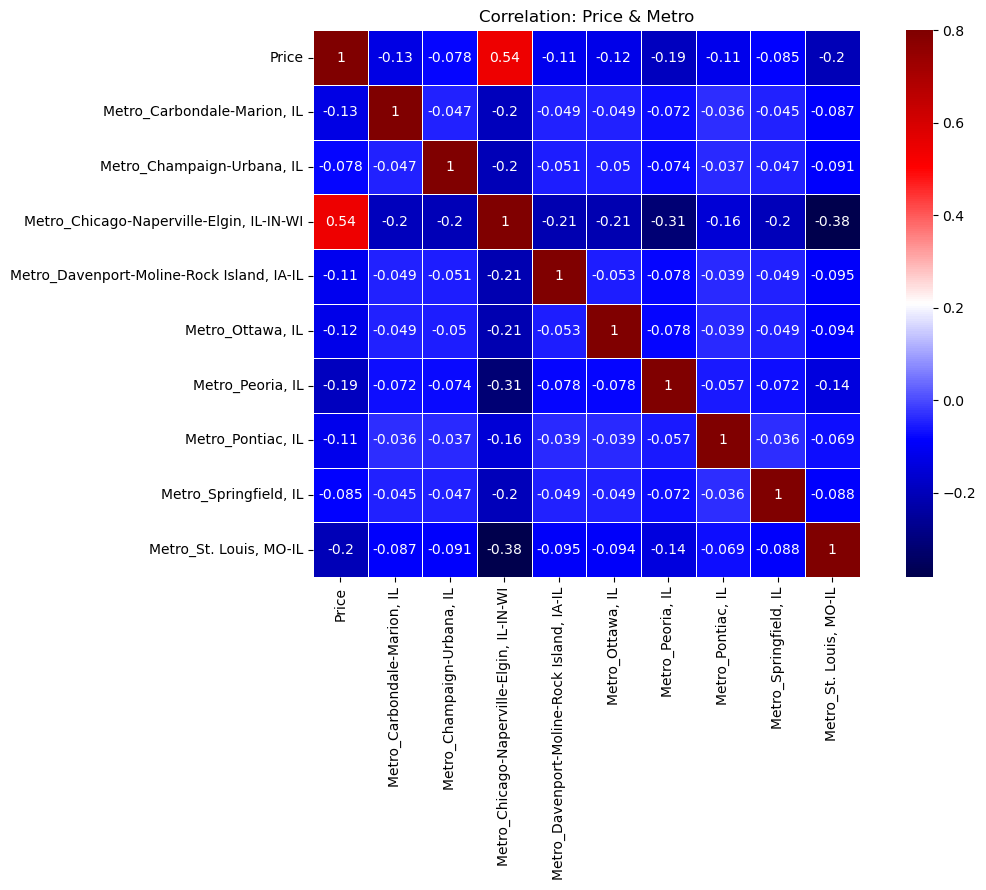

In [19]:
# Top 10 metro areas by number of rows
top_metros = IL_last5['Metro'].value_counts().head(10).index

# Filter to those metros
df_filtered = IL_last5[IL_last5['Metro'].isin(top_metros)]
df_corr = pd.get_dummies(df_filtered[['Metro', 'Price']], drop_first=True)

corrmatrix = df_corr.corr()

# Step 4: Plot heatmap
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmatrix, vmax=0.8, square=True, annot=True, cmap='seismic', linewidths=0.5)
plt.title('Correlation: Price & Metro')
plt.tight_layout()
plt.show()

After doing a deep dive into this daya, I can still see that the Chicago and surrounding suburbs area is the only one with a slightly positive correlation to home value prices at (0.54). All other metro areas have aweak negative correlation, with Peoria, IL having the lowest correlation to home value prices at (-0.19), followed by Carbondale-Marion, IL (-0.13) and Ottawa, IL (-0.12). Reducing the number of metro areas did not give us a higher or weaker correlation either.

### Summary

These findings were not very surprising, LA, Seattle, and Miami had metro areas that were just moderately positively correlated with higher prices. To observe a higher corrlation to pricing for the Chicago area, we had to narrow down our analysis to just Illinois.

If I was to take this a step further, I would like to see home value prices by town or neighborhood, and not just metro area. For example, I live in Evanston, IL, and most houses in my neighborhood are around a million; however, in Naperville or Elgin, there is plenty of housing below \\$500,000. Neighborhoods in Chicago have varying prices too.

As most of us know, housing prices vary by neighborhood, especially in major cities, and I think this is one reason our correlation values were not stronger.

Overall, there were no major difficulties with this data, other than it being very large and having a large number of missing values. Since it was wide data it was hard to format to long data. Another difficulty was that my price value kept rounding to a large number of decimelas, so I ahd to keep rounding it to 2 decimal places for all my displays.

I think one shortcoming in this project is the fact that I did not get to do an analysis by neighborhood or town. I think there is a lot of variability in home prices in areas like the Chicago Metro area, which in this data included parts of Wisconsing and Indiana, as well as Illinois. It would be more informative to narrow down the analysis by neighborhood or individual town.
